In [112]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import sys
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']= 100
#%pylab inline
plt.rcParams['figure.figsize'] = (10, 6)

## Importing and cleaning data.

In [113]:
# Load json file
data = []
with open('hourlyAggregate.json') as file:
    for line in file:
        data.append(json.loads(line))

In [114]:
df = pd.DataFrame(data)
dataset = df[(df['attributeId'] == '001')&(df['attributeType'] == 'DM')&(df['deviceId'] == '82e01120-52de-11e8-b207-0f00225de25b')]
dataset = dataset[['timeStamp', 'closingValue']]
dataset.head()

,timeStamp,closingValue
19142,2018-06-01 12:00:00,4.380000
19143,2018-06-01 13:00:00,4.396667
19144,2018-06-01 14:00:00,4.413333
19145,2018-06-01 15:00:00,4.430000
19146,2018-06-01 16:00:00,4.446667


In [115]:
# Converting to timestamp to datetime and setting it as index
dataset['timeStamp'] = dataset['timeStamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
dataset.set_index('timeStamp', inplace = True)
dataset.sort_index(inplace = True)
dataset.head()

,closingValue
timeStamp,
2018-06-01 12:00:00,4.380000
2018-06-01 13:00:00,4.396667
2018-06-01 14:00:00,4.413333
2018-06-01 15:00:00,4.430000
2018-06-01 16:00:00,4.446667


In [116]:
# Fixing missing timestamps if any.
start = dataset.index[0]
end = dataset.index[-1]
dates = pd.date_range(start=start, end=end, freq='H')
dataset = dataset.reindex(dates)
dataset.interpolate(how = 'linear', inplace = True)

In [117]:
vals_lower = dataset['closingValue'].values[:-1]
vals_upper = dataset['closingValue'].values[1:]
increment = vals_upper - vals_lower

In [118]:
dataset.drop(dataset.index[0], inplace = True)
dataset['increment'] = increment
dataset.drop(columns = 'closingValue', inplace = True)

In [119]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset[['increment']] = scaler.fit_transform(dataset[['increment']])

In [120]:
def next_batch(training_data,batch_size,steps):
        
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,high=len(training_data)-steps)

    # Create Y data for time series in the batches
    data = np.array(train_set[rand_start:rand_start+steps+1]).reshape(1,steps+1)
 
    return data[:, :-1].reshape(-1, steps, 1), data[:, 1:].reshape(-1, steps, 1)

In [121]:
dataset.shape

(6338, 1)

In [122]:
train_set, test_set = dataset[:6000], dataset[6000:]

## Create and Train Model

In [123]:
tf.reset_default_graph()

# Just one feature, the time series
num_inputs = 1
num_time_steps = 72
num_neurons = 400
num_outputs = 1
learning_rate = 0.0005
num_train_iterations = 20000

# Size of the batch of data
batch_size = 1

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.tanh),
    output_size=num_outputs) 

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32,parallel_iterations=64)
outputs.get_shape()


loss = tf.reduce_mean(tf.square(outputs - y)) 

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,momentum=0.5,centered=True,decay=0.2)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)


In [124]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_set, batch_size, num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch,y:y_batch})
        
        if iteration % 5 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration, mse)
            
    saver.save(sess, "./MeterHourly.ckpt") 



0 0.025115492
5 0.0036203477
10 0.0005463758
15 0.011511777
20 0.010643978
25 0.010195767
30 0.009477072
35 0.018905375
40 9.9082616e-05
45 0.018719694
50 0.018843807
55 0.007914947
60 0.010904442
65 0.0014461244
70 1.3541927e-05
75 0.0014501364
80 0.005238444
85 0.0045746984
90 0.0069636554
95 0.0037322757
100 0.021080313
105 0.0051880423
110 7.0936214e-05
115 0.012307009
120 0.005382348
125 0.00848973
130 0.011021333
135 0.0021570353
140 0.0050983494
145 0.006296786
150 0.021072825
155 0.001366816
160 0.004245099
165 0.0026927409
170 0.00525264
175 0.008153076
180 0.0029951392
185 0.0073007313
190 0.007102201
195 0.001639856
200 0.0058418526
205 0.0039312397
210 0.0052450574
215 0.006396335
220 0.009625296
225 0.0015732547
230 0.01399559
235 0.0142263705
240 0.0031314858
245 0.004299413
250 0.0036200397
255 0.0027729794
260 0.00950089
265 0.010614727
270 9.632615e-06
275 0.011492923
280 0.012598374
285 0.004447954
290 0.009992049
295 0.0057055866
300 0.006956637
305 0.0134940315
310 

In [125]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    #saver.restore(sess, "/home/infd-003/sequence_model_poc/model_saved/ex_time_series_model1.ckpt")
    saver.restore(sess, "./MeterHourly.ckpt")

    train_seed = list(np.array(train_set[-num_time_steps:]))
    
    ## Now create a for loop that 
    for iteration in range(100):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(-1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./MeterHourly.ckpt


In [126]:
len(train_seed[num_time_steps:])

100

In [127]:
new_test_set = test_set.head(100)

In [128]:
results = np.array(train_seed[num_time_steps:]).reshape(100,1)

In [129]:
new_test_set['predicted'] = results

C:\Users\swara\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


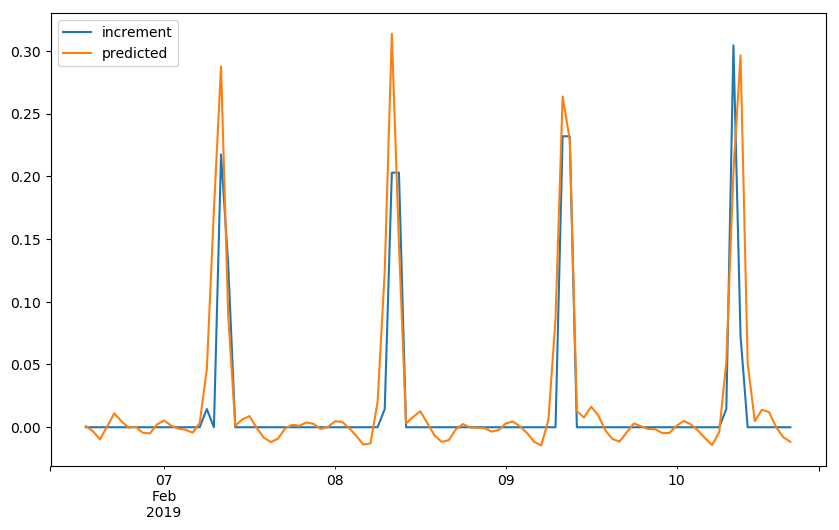

In [130]:
new_test_set.plot()